In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit

import sys
sys.path.append('../shared')

from bartolozziSPEED import *

In [6]:
A_SPACE = np.linspace(1.8,2,1)
SIM = 1
plot = False


RVAR_STANDARD = np.zeros((len(A_SPACE), SIM))
RVAR = np.zeros((len(A_SPACE), SIM))

for j, A_val in enumerate(A_SPACE):
    for l in range(SIM):

        # Default
        # pd = 0.1
        # pe = 0.0001
        # ph = 0.1 
        # pa = 0.5
        # N0 = 2000
        # N1 = 200
        # A = 2
        # a = 0.1
        # h = 0.1
        
        A = A_val # interaction strength between agents
        a = 2*A # randomness of A 
        h = 0  # external field reflecting the effects of the environmnet

        pd = 0.05  # probability that an active trader diffuses and becomes inactive
        pe = 0.0001 # probability that a nontrading enters the market
        ph = 0.0493 # probability that an active trader can turn one of his inactive neighbors into an active one
        pa = 1 # active and inactive distribution 

        N0 = 512 # timepoints
        N1 = 128  # granulization of the grid / agents

        

        G, RVAR_ARRAY = generate(pd, pe, ph, pa, N0, N1, A, a, h)
        RVAR[j, l]= np.sum(RVAR_ARRAY**2)
        
        # PLOT

        if plot ==True:
            x = RVAR_ARRAY
            fig, (ax1, ax2, ax3) = plt.subplots(
                ncols=1, nrows=3, figsize=(12,5), sharex=True, gridspec_kw = {'wspace':0, 'hspace':0}
            )
            ax1.imshow(G.T, cmap="binary", interpolation="None", aspect="auto")

            r = (x - np.mean(x)) / np.std(x)
            s = 100
            S = np.zeros_like(x)
            S[0] = s
            for i in range(1,N0):
                S[i] = S[i-1] + (S[i-1] * r[i]/100) + 0.01


            ax1.set_ylabel("agents")

            ax2.plot(S)
            ax2.grid(alpha=0.4)
            ax2.set_ylabel("close price")


            ax3.grid(alpha=0.4)
            ax3.plot(x)
            ax3.set_ylabel("log return")
            ax3.set_xlabel("time")


            plt.tight_layout()
            plt.show()

In [7]:
@jit(nopython=True)
def genhurst(S,q):

    start = 2 
    stop = 100

    L=len(S)       
    # if L < 100:
    #     warnings.warn('Data series very short!')
       
    H = np.zeros((len(range(start,stop)),1))
    k = 0
    
    for Tmax in range(start, stop):
        
        x = np.arange(1,Tmax+1,1)
        mcord = np.zeros((Tmax,1))
        
        for tt in range(1,Tmax+1):
            dV = S[np.arange(tt,L,tt)] - S[np.arange(tt,L,tt)-tt] 
            VV = S[np.arange(tt,L+tt,tt)-tt]
            N = len(dV) + 1
            X = np.arange(1,N+1,dtype=np.float64)
            Y = VV
            mx = np.sum(X)/N
            SSxx = np.sum(X**2) - N*mx**2
            my = np.sum(Y)/N
            SSxy = np.sum( np.multiply(X,Y))  - N*mx*my
            cc1 = SSxy/SSxx
            cc2 = my - cc1*mx
            ddVd = dV - cc1
            VVVd = VV - np.multiply(cc1,np.arange(1,N+1,dtype=np.float64)) - cc2
            mcord[tt-1] = np.mean( np.abs(ddVd)**q )/np.mean( np.abs(VVVd)**q )
            
        mx = np.mean(np.log10(x))
        SSxx = np.sum( np.log10(x)**2) - Tmax*mx**2
        my = np.mean(np.log10(mcord))
        SSxy = np.sum( np.multiply(np.log10(x),np.transpose(np.log10(mcord)))) - Tmax*mx*my
        H[k] = SSxy/SSxx
        k = k + 1
        
    mH = np.mean(H)/q
    
    return mH

In [8]:
x =RVAR_ARRAY

r = (x - np.mean(x)) / np.std(x)

s = 1400
S = np.zeros_like(x)
S[0] = s
for i in range(1, N0):
    S[i] = S[i-1] + (S[i-1] * r[i]/100)

q_vals = np.linspace(1, 5, 30)
h_res = np.zeros(q_vals.shape[0])

for i, val in enumerate(q_vals):
    h_res[i] = genhurst(S, val)

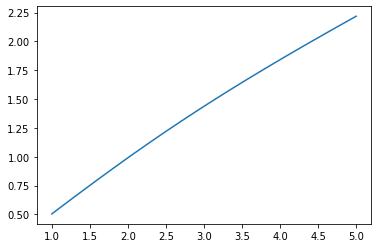

In [9]:
plt.plot(q_vals, q_vals*h_res)

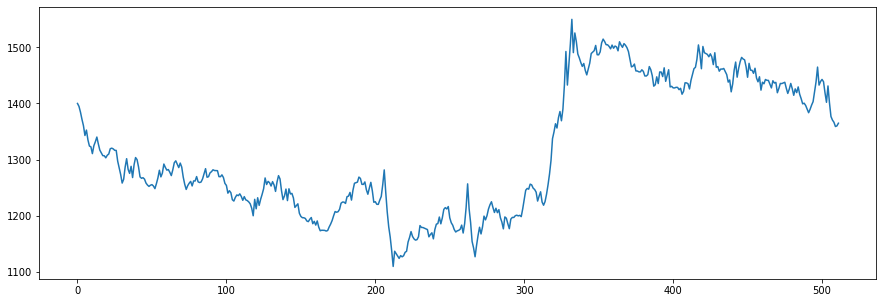

In [10]:
plt.figure(figsize=(15,5))
plt.plot(S)

<ipython-input-13-a64e1e42d92f>:3: RuntimeWarning: invalid value encountered in true_divide
  RVAR_STD= RVAR_STD/np.max(RVAR_STD)


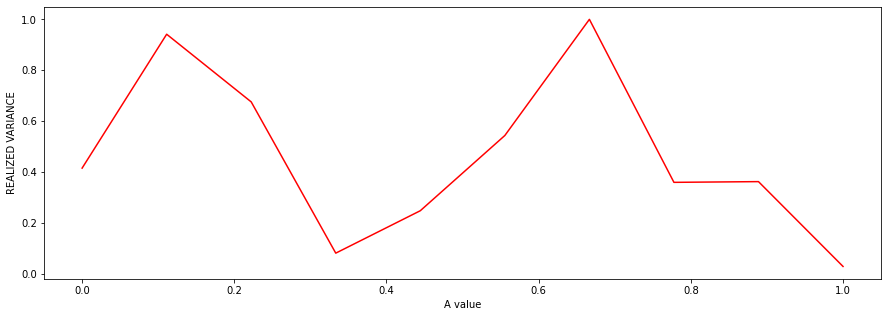

In [13]:
RVAR_MEAN = np.mean(RVAR, axis=1)
RVAR_STD = np.std(RVAR, axis=1)
RVAR_STD= RVAR_STD/np.max(RVAR_STD)

Y1 = RVAR_MEAN/np.max(RVAR_MEAN)+1.96*(RVAR_STD)/np.sqrt(SIM)
Y2 = RVAR_MEAN/np.max(RVAR_MEAN)-1.96*(RVAR_STD)/np.sqrt(SIM)

plt.figure(figsize=(15,5))
plt.plot(A_SPACE, RVAR_MEAN/np.max(RVAR_MEAN), color="r")
plt.fill_between(x=A_SPACE, y1 =Y1, y2=Y2)
plt.xlabel("A value")
plt.ylabel("REALIZED VARIANCE")
plt.show()

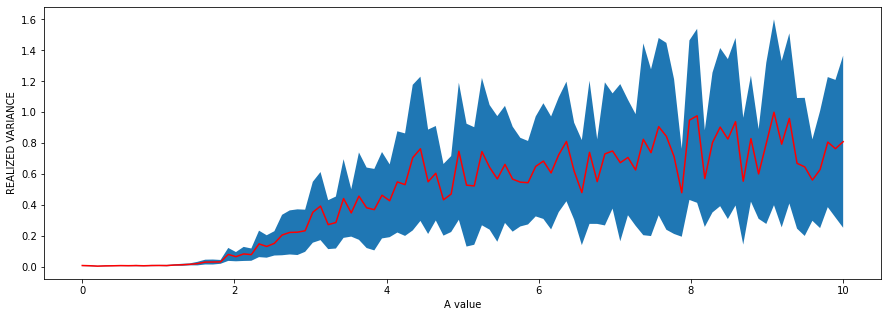

In [50]:
RVAR2 = np.load("CA_100sim_2000N0_Arange(0,10,100).npy")
RVAR_MEAN2 = np.mean(RVAR2, axis=1)
RVAR_STD2 = np.std(RVAR2, axis=1)
RVAR_STD2= RVAR_STD2/np.max(RVAR_STD2)

Y1 = RVAR_MEAN2/np.max(RVAR_MEAN2)+1.96*(RVAR_STD2)/np.sqrt(100)
Y2 = RVAR_MEAN2/np.max(RVAR_MEAN2)-1.96*(RVAR_STD2)/np.sqrt(100)

plt.figure(figsize=(15,5))
plt.plot(A_SPACE, RVAR_MEAN2/np.max(RVAR_MEAN2), color="r")
plt.fill_between(x=A_SPACE, y1 =Y1, y2=Y2)
plt.xlabel("A value")
plt.ylabel("REALIZED VARIANCE")
plt.show()

In [31]:
RVAR_STD/np.max(RVAR_STD)

array([0.00584158, 0.00571303, 0.00320149, 0.00475359, 0.00417657,
       0.00584396, 0.00538863, 0.00661943, 0.00578196, 0.00642858,
       0.00609171, 0.00706218, 0.00741085, 0.01042487, 0.01015188,
       0.01844671, 0.02486581, 0.02588914, 0.02000337, 0.06757933,
       0.04816633, 0.07328812, 0.06414542, 0.13790712, 0.11692119,
       0.12678924, 0.21085994, 0.22974711, 0.23818516, 0.21968952,
       0.31755251, 0.35496538, 0.25512716, 0.2709177 , 0.41021272,
       0.24710349, 0.45537897, 0.41953565, 0.4248095 , 0.45056887,
       0.379586  , 0.52787195, 0.53438624, 0.75921353, 0.7520063 ,
       0.5441365 , 0.49256193, 0.37358759, 0.39587307, 0.714683  ,
       0.64042273, 0.61286482, 0.76827041, 0.64980614, 0.65493378,
       0.61037828, 0.54755907, 0.46207664, 0.43516167, 0.52105354,
       0.60309771, 0.58886381, 0.59832863, 0.62348787, 0.505319  ,
       0.54770249, 0.74609431, 0.44077808, 0.74589048, 0.6005528 ,
       0.81958165, 0.60248676, 0.58210863, 1.        , 0.86949